# Image Prediction Demo

This notebook demonstrates how to load a trained model and make predictions on trash images.

In [1]:
import torch
from PIL import Image
from torchvision import transforms
import glob
import torchvision.transforms.functional as F

from trashsorting.model import TrashModel

/workspaces/trash-image-sorting/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load the Trained Model

Load the model from the checkpoint file. We'll use the best model saved during training.

In [2]:
# Get the best checkpoint
checkpoint_pattern = '../models/best-*.ckpt'
matching_files = glob.glob(checkpoint_pattern)

if not matching_files:
    raise FileNotFoundError(f"No checkpoint files found matching pattern: {checkpoint_pattern}")

model_path = matching_files[0]  # Get the first (or only) matching file
model = TrashModel.load_from_checkpoint(model_path)
model.eval()  # Set to evaluation mode

print(f"\nModel loaded successfully!")
print(f"Model architecture: {model.hparams.model_name}")
print(f"Number of classes: {model.hparams.num_classes}")


Model loaded successfully!
Model architecture: mobilenetv3_small_100
Number of classes: 6


Define class names

In [25]:
# TrashNet class names
class_names = ["cardboard", "glass", "metal", "paper", "plastic", "trash"]

Define prediction function

In [27]:
def predict_image(image_tensor: torch.Tensor, model: TrashModel, class_names: list) -> dict:
    """
    Predict the class of a trash image.
    
    Args:
        image_path: Path to the image file
        model: Trained PyTorch Lightning model
        preprocess: Image preprocessing transforms
        class_names: List of class names
    
    Returns:
        Dictionary with prediction results
    """
    
    # Make prediction
    with torch.no_grad():
        logits = model(image_tensor)
        probabilities = torch.softmax(logits, dim=1)[0]
        predicted_idx = int(torch.argmax(probabilities).item())
        confidence = probabilities[predicted_idx].item()
    
    # Get all class probabilities
    class_probs = {class_names[i]: probabilities[i].item() for i in range(len(class_names))}
    
    return {
        "predicted_class": class_names[predicted_idx],
        "confidence": confidence,
        "all_probabilities": class_probs,
        "image_tensor": image_tensor
    }

## Example: Predict on a Test Image

Let's load a sample image from the dataset and make a prediction.

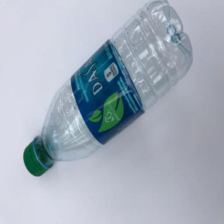

In [19]:
# Load a sample from the dataset
import os
from trashsorting.data import TrashDataPreprocessed
from trashsorting.utils.transform import denormalize

# if preprocessed file are not found, raise error
preprocessed_file_path = "../data/processed/trashnet.pt"
if not os.path.exists(preprocessed_file_path):
    raise FileNotFoundError(f"Preprocessed file not found at {preprocessed_file_path}. Please run the preprocessing step first.")

# Load test dataset to get a sample image
test_dataset = TrashDataPreprocessed("../data/", split="test", fraction=1.0)

# Get a random sample
sample_idx = 255
sample = test_dataset[sample_idx]
sample_tensor = sample[0]
true_label = sample[1]

denormalized_tensor = denormalize()(sample_tensor)

# Convert tensor to PIL Image for display
sample_image = F.to_pil_image(denormalized_tensor)
display(sample_image)

In [20]:
# Save the sample image temporarily to predict on it
import tempfile
from trashsorting.utils.transform import image_transform

with tempfile.NamedTemporaryFile(suffix=".jpg", delete=False) as tmp:
    sample_image.save(tmp.name)
    tmp_path = tmp.name

# Make prediction
result = predict_image(sample_tensor.unsqueeze(0), model, class_names)

print(f"\nPrediction Results:")
print(f"Predicted class: {result['predicted_class']}")
print(f"Confidence: {result['confidence']:.2%}")
print(f"\nAll class probabilities:")
for class_name, prob in sorted(result['all_probabilities'].items(), key=lambda x: x[1], reverse=True):
    print(f"  {class_name:10s}: {prob:.2%}")

# Clean up temp file
import os
os.unlink(tmp_path)

Shape of input tensor: torch.Size([1, 3, 224, 224])

Prediction Results:
Predicted class: plastic
Confidence: 99.96%

All class probabilities:
  plastic   : 99.96%
  glass     : 0.04%
  metal     : 0.00%
  cardboard : 0.00%
  paper     : 0.00%
  trash     : 0.00%


We visualize predictions and class probabilities

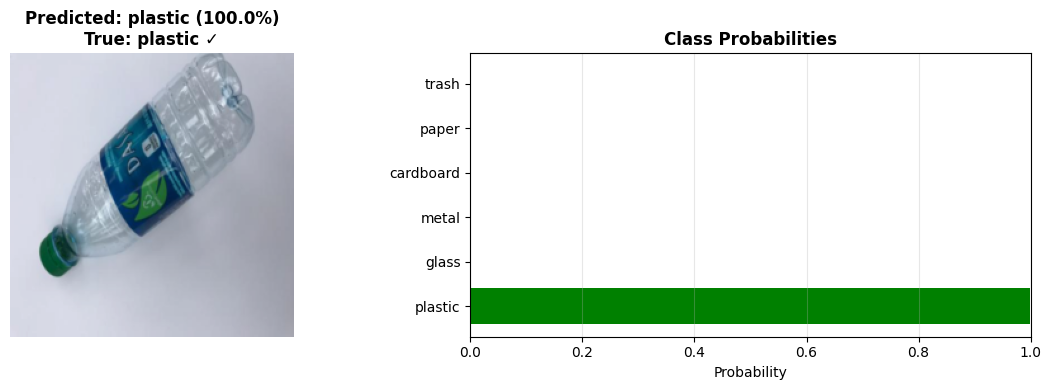

In [21]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_prediction(result: dict, true_label: str):
    """
    Visualize prediction results with image and probability bar chart.
    
    Args:
        result: Prediction result dictionary
        true_label: True label for comparison
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    # Convert tensor to displayable image
    # Remove batch dimension and denormalize
    image_tensor = result['image_tensor'].squeeze(0)
    denormalized_tensor = denormalize()(image_tensor)
    display_image = F.to_pil_image(denormalized_tensor)
    
    # Display image
    ax1.imshow(display_image)
    ax1.axis('off')
    
    title = f"Predicted: {result['predicted_class']} ({result['confidence']:.1%})"
    if true_label:
        title += f"\nTrue: {true_label}"
        if result['predicted_class'] == true_label:
            title += " ✓"
        else:
            title += " ✗"
    ax1.set_title(title, fontsize=12, fontweight='bold')
    
    # Plot probabilities
    probs = result['all_probabilities']
    classes = list(probs.keys())
    values = list(probs.values())
    
    # Sort by probability
    sorted_indices = np.argsort(values)[::-1]
    classes = [classes[i] for i in sorted_indices]
    values = [values[i] for i in sorted_indices]
    
    # Color the predicted class differently
    colors = ['green' if c == result['predicted_class'] else 'skyblue' for c in classes]
    
    ax2.barh(classes, values, color=colors)
    ax2.set_xlabel('Probability', fontsize=10)
    ax2.set_xlim([0, 1])
    ax2.set_title('Class Probabilities', fontsize=12, fontweight='bold')
    ax2.grid(axis='x', alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Visualize the prediction
visualize_prediction(result, true_label=class_names[true_label])

## Predict on Multiple Images

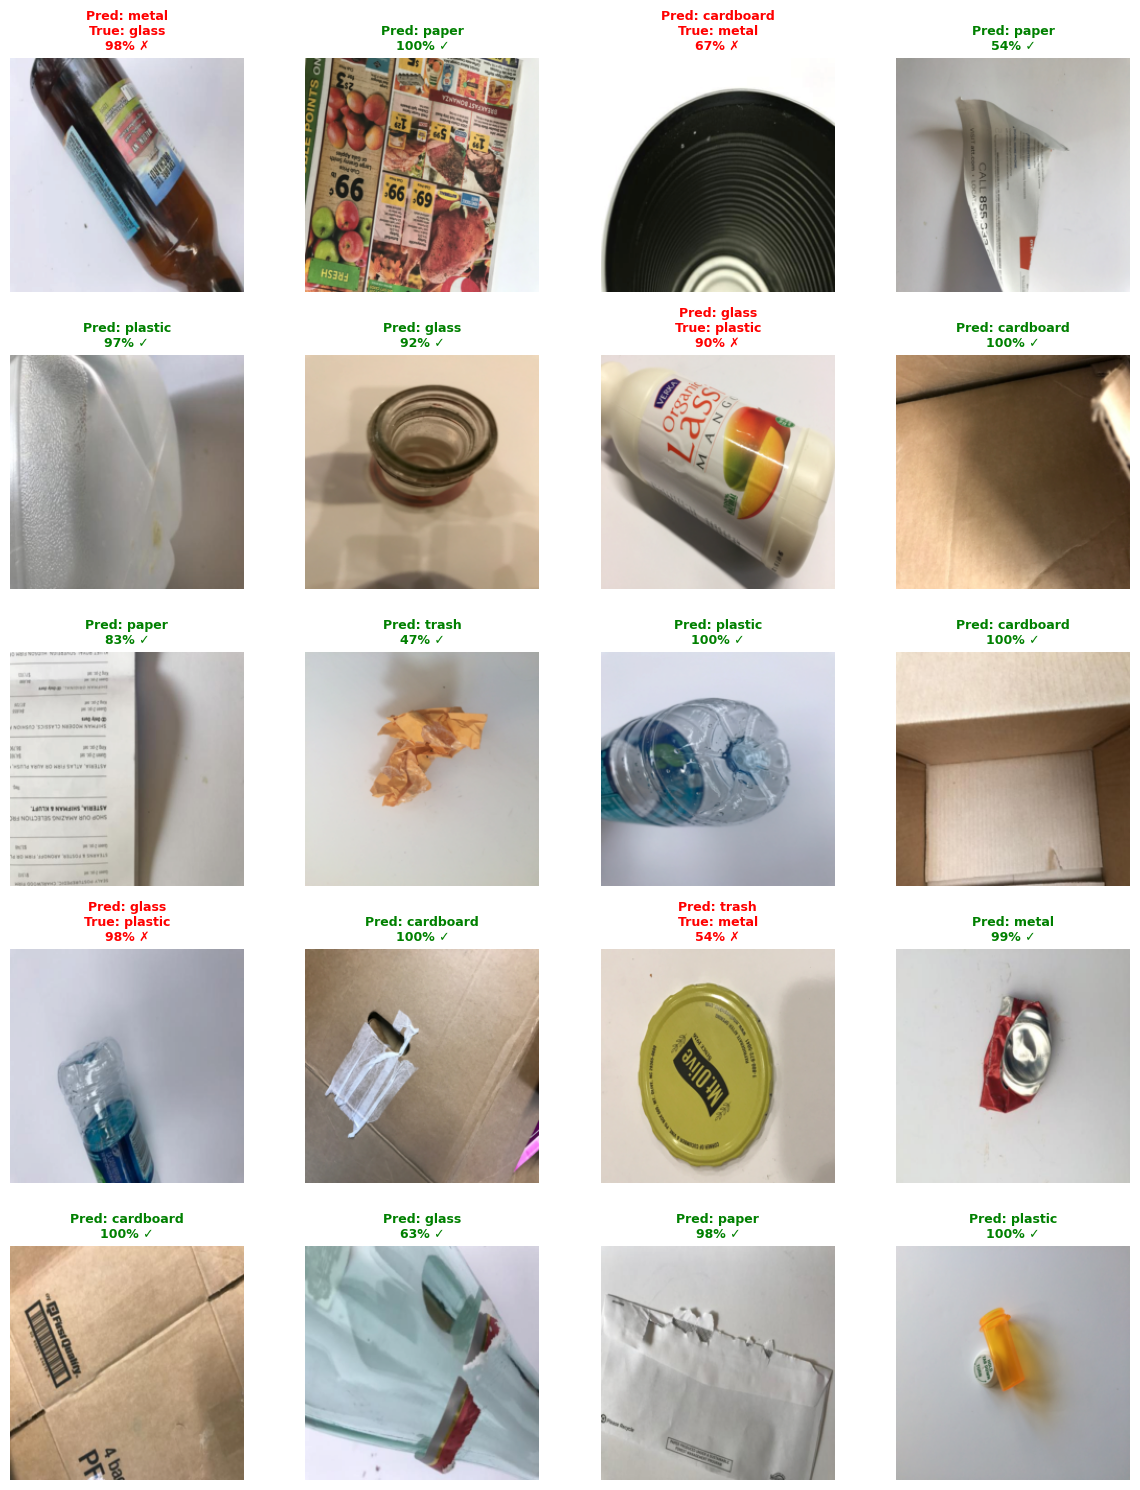


Accuracy on these 20 samples: 15/20 (75.0%)


In [30]:
# Test on multiple samples with grid visualization
num_samples = 20
indices = np.random.choice(len(test_dataset), num_samples, replace=False)

# Collect all predictions
results = []
for idx in indices:
    sample = test_dataset[int(idx)]
    sample_tensor = sample[0]
    true_label = sample[1]
    
    # Make prediction
    result = predict_image(sample_tensor.unsqueeze(0), model, class_names)
    
    results.append({
        'result': result,
        'true_label': class_names[true_label]
    })

# Create compact grid visualization
n_cols = 4
n_rows = (num_samples + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 3 * n_rows))
axes = axes.flatten()

for i, item in enumerate(results):
    result = item['result']
    true_label = item['true_label']
    
    # Convert tensor to displayable image
    image_tensor = result['image_tensor'].squeeze(0)
    denormalized_tensor = denormalize()(image_tensor)
    display_image = F.to_pil_image(denormalized_tensor)
    
    # Display image
    axes[i].imshow(display_image)
    axes[i].axis('off')
    
    # Create title with prediction info
    is_correct = result['predicted_class'] == true_label
    marker = "✓" if is_correct else "✗"
    color = 'green' if is_correct else 'red'
    
    title = f"Pred: {result['predicted_class']}\n{result['confidence']:.0%} {marker}"
    if not is_correct:
        title = f"Pred: {result['predicted_class']}\nTrue: {true_label}\n{result['confidence']:.0%} {marker}"
    
    axes[i].set_title(title, fontsize=9, fontweight='bold', color=color)

# Hide any unused subplots
for i in range(len(results), len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()

# Print summary statistics
correct = sum(1 for item in results if item['result']['predicted_class'] == item['true_label'])
print(f"\nAccuracy on these {num_samples} samples: {correct}/{num_samples} ({correct/num_samples*100:.1f}%)")

## Model Performance Summary

Evaluating on 759 test samples...
  Processed 50/759 samples
  Processed 100/759 samples
  Processed 150/759 samples
  Processed 200/759 samples
  Processed 250/759 samples
  Processed 300/759 samples
  Processed 350/759 samples
  Processed 400/759 samples
  Processed 450/759 samples
  Processed 500/759 samples
  Processed 550/759 samples
  Processed 600/759 samples
  Processed 650/759 samples
  Processed 700/759 samples
  Processed 750/759 samples

OVERALL TEST SET PERFORMANCE
Total samples: 759
Correct predictions: 632
Overall Accuracy: 83.27%

PER-CLASS ACCURACY
cardboard   : 94.21% (114/121 correct)
glass       : 85.51% (118/138 correct)
metal       : 80.95% (102/126 correct)
paper       : 82.66% (143/173 correct)
plastic     : 76.40% (123/161 correct)
trash       : 80.00% ( 32/ 40 correct)

DETAILED CLASSIFICATION REPORT
              precision    recall  f1-score   support

   cardboard     0.8201    0.9421    0.8769       121
       glass     0.8082    0.8551    0.8310       138

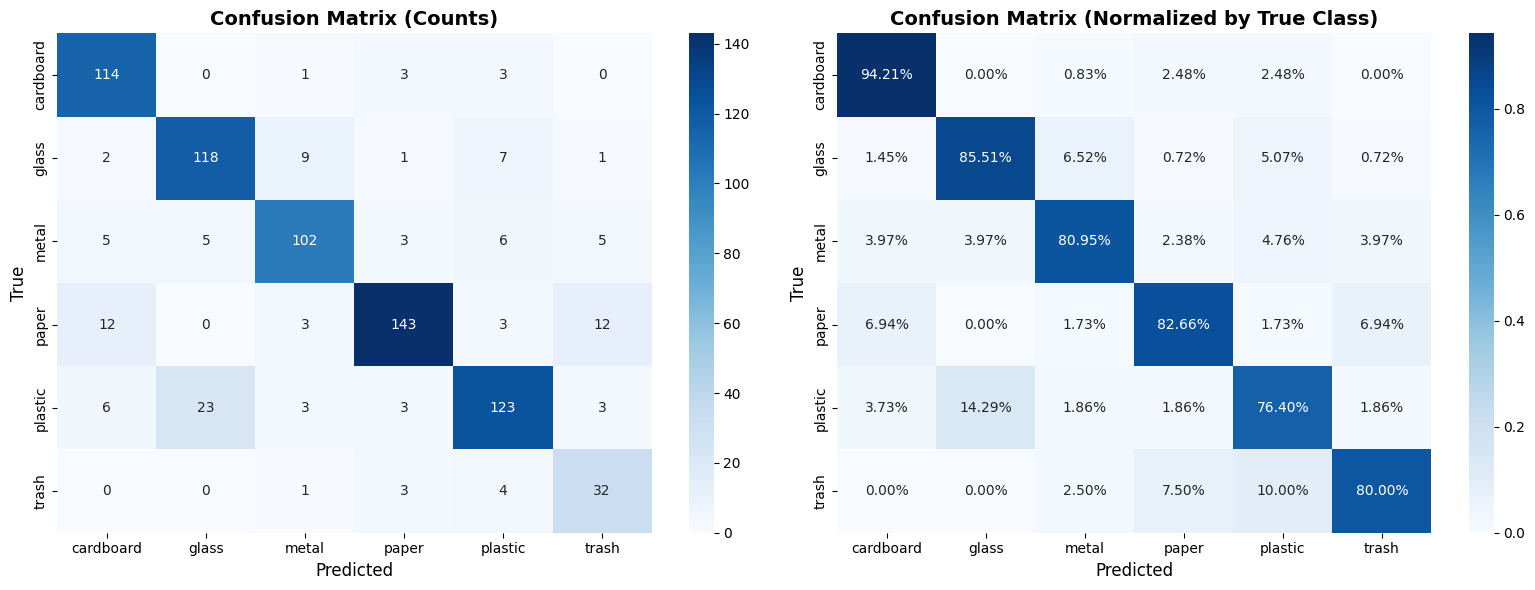


MOST COMMON MISCLASSIFICATIONS
plastic      → glass       :  23 times
paper        → cardboard   :  12 times
paper        → trash       :  12 times
glass        → metal       :   9 times
glass        → plastic     :   7 times
metal        → plastic     :   6 times
plastic      → cardboard   :   6 times
metal        → cardboard   :   5 times
metal        → glass       :   5 times
metal        → trash       :   5 times


In [29]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Evaluate on full test set (use a fraction for faster evaluation)
test_dataset_full = TrashDataPreprocessed("../data/", split="test", fraction=1.0)

y_true = []
y_pred = []

print(f"Evaluating on {len(test_dataset_full)} test samples...")

for i in range(len(test_dataset_full)):
    sample = test_dataset_full[i]
    sample_tensor = sample[0]
    true_label = sample[1]
    
    # Make prediction
    result = predict_image(sample_tensor.unsqueeze(0), model, class_names)
    
    y_true.append(true_label)
    y_pred.append(class_names.index(result['predicted_class']))
    
    if (i + 1) % 50 == 0:
        print(f"  Processed {i + 1}/{len(test_dataset_full)} samples")

# Calculate overall accuracy
correct = sum(1 for i in range(len(y_true)) if y_true[i] == y_pred[i])
overall_accuracy = correct / len(y_true)

print(f"\n{'='*60}")
print(f"OVERALL TEST SET PERFORMANCE")
print(f"{'='*60}")
print(f"Total samples: {len(y_true)}")
print(f"Correct predictions: {correct}")
print(f"Overall Accuracy: {overall_accuracy*100:.2f}%")
print(f"{'='*60}\n")

# Calculate per-class accuracy
print(f"{'='*60}")
print(f"PER-CLASS ACCURACY")
print(f"{'='*60}")
for i, class_name in enumerate(class_names):
    # Find all samples of this class
    class_indices = [j for j, label in enumerate(y_true) if label == i]
    if len(class_indices) == 0:
        continue
    
    # Calculate accuracy for this class
    class_correct = sum(1 for j in class_indices if y_pred[j] == i)
    class_accuracy = class_correct / len(class_indices)
    
    print(f"{class_name:12s}: {class_accuracy*100:5.2f}% ({class_correct:3d}/{len(class_indices):3d} correct)")

print(f"{'='*60}\n")

# Print detailed classification report
print(f"DETAILED CLASSIFICATION REPORT")
print(f"{'='*60}")
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

# Plot confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Create figure with two subplots: raw counts and normalized percentages
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Raw counts
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names, ax=ax1)
ax1.set_xlabel('Predicted', fontsize=12)
ax1.set_ylabel('True', fontsize=12)
ax1.set_title('Confusion Matrix (Counts)', fontsize=14, fontweight='bold')

# Normalized by true class (shows what percentage of each class was predicted as what)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names, ax=ax2)
ax2.set_xlabel('Predicted', fontsize=12)
ax2.set_ylabel('True', fontsize=12)
ax2.set_title('Confusion Matrix (Normalized by True Class)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

# Print most common misclassifications
print(f"\n{'='*60}")
print(f"MOST COMMON MISCLASSIFICATIONS")
print(f"{'='*60}")
misclassifications = []
for i in range(len(class_names)):
    for j in range(len(class_names)):
        if i != j and cm[i, j] > 0:
            misclassifications.append((class_names[i], class_names[j], cm[i, j]))

# Sort by count
misclassifications.sort(key=lambda x: x[2], reverse=True)

# Show top 10
for true_class, pred_class, count in misclassifications[:10]:
    print(f"{true_class:12s} → {pred_class:12s}: {count:3d} times")

print(f"{'='*60}")